In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import seaborn as sns
from sklearn import metrics
import joblib

# Used CSV Files in This Notebook Can Be Reached Via The Link Given Below
https://drive.google.com/drive/folders/1LJBghznfrr3SfxHZ8sUenAc6pdhb5vKK?usp=sharing

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BİTİRME/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
print(df.shape)
df = df[df.Class != 2]
df.shape

(1262, 11619)


(949, 11619)

In [3]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

# PCA

In [4]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size= 0.22, random_state = 41)

In [6]:
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

# CNN ARCHITECTURE

In [7]:
Batch_size = 32
def build_model(TIME_PERIODS):
    input_shape=(TIME_PERIODS,)
    model = Sequential()
    model.add(keras.Input(shape=(TIME_PERIODS,1)))
    model.add(Conv1D(512, 2,strides=2,input_shape=(TIME_PERIODS,1)))
    model.add(Activation('relu'))
    model.add(Conv1D(512, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(256, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(256, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 1,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 1,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(32, 1,strides=1, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return(model)

In [8]:
ckpt = keras.callbacks.ModelCheckpoint(
        filepath='C:/Users/norma/Desktop/BITIRME/Models/CNN/best_model.{epoch:02d}-{val_categorical_accuracy:.4f}.h5',
        monitor='val_categorical_accuracy', save_best_only=True,verbose=1)

callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='auto', verbose=1, min_delta=0.0001),
         ckpt]

cnn = build_model(principalDf.shape[1])
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='categorical_crossentropy',
            optimizer=opt, metrics=['categorical_accuracy'])

In [9]:
history = cnn.fit(
      x_train,y_train,
      steps_per_epoch=len(principalDf)//Batch_size,
      validation_data=(x_test, y_test),
      epochs=15,
      callbacks=[callbacks]
      )

y_pred = cnn.predict(x_test)

Epoch 1/15
29/29 [==============================] - 5s 125ms/step - loss: 0.6930 - categorical_accuracy: 0.5230 - val_loss: 0.6937 - val_categorical_accuracy: 0.4163

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41627, saving model to C:/Users/norma/Desktop/BITIRME/Models/CNN\best_model.01-0.4163.h5
Epoch 2/15
29/29 [==============================] - 4s 136ms/step - loss: 0.6922 - categorical_accuracy: 0.5365 - val_loss: 0.6938 - val_categorical_accuracy: 0.4163

Epoch 00002: val_categorical_accuracy did not improve from 0.41627
Epoch 3/15
29/29 [==============================] - 4s 153ms/step - loss: 0.6903 - categorical_accuracy: 0.5311 - val_loss: 0.6939 - val_categorical_accuracy: 0.4163

Epoch 00003: val_categorical_accuracy did not improve from 0.41627
Epoch 4/15
29/29 [==============================] - 3s 112ms/step - loss: 0.6899 - categorical_accuracy: 0.5446 - val_loss: 0.6936 - val_categorical_accuracy: 0.4163

Epoch 00004: val_categorical_accuracy did not i

In [10]:
class_d = 'C:/Users/norma/Desktop/BİTİRME/BITIRME(linux)/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test_encoded = encoder.inverse_transform(y_test).ravel()

In [11]:
y_pred_ = np.argmax(y_pred, axis=1)

Classification report : 
               precision    recall  f1-score   support

           0       0.59      0.86      0.70        87
           1       0.85      0.57      0.68       122

    accuracy                           0.69       209
   macro avg       0.72      0.71      0.69       209
weighted avg       0.74      0.69      0.69       209



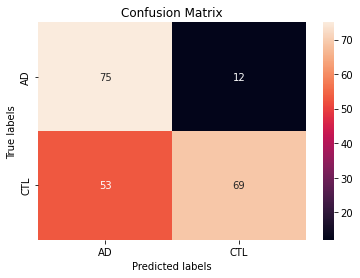

In [12]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test_encoded, y_pred_,labels=[0,1])
print('Classification report : \n',matrix)

labels_ = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test_encoded, y_pred_)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels_);



dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


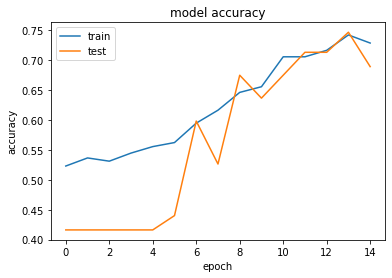

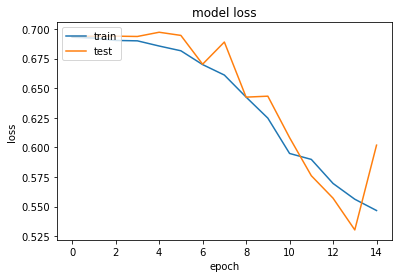

In [13]:
print("\n")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# AUC - ROC

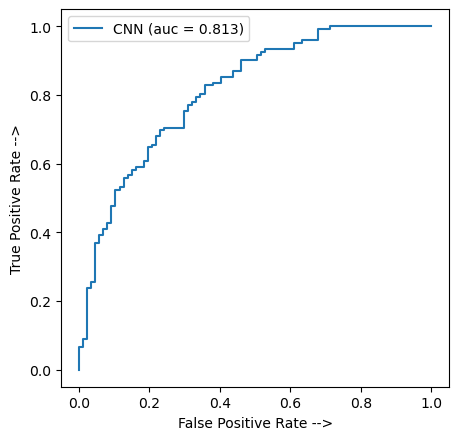

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_encoded, y_pred[:,1])
auc_cnn = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'CNN (auc = %0.3f)' % auc_cnn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Save Model

In [15]:
cnn.save("C:/Users/norma/Desktop/src/CNN.h5")

# Load Model

In [16]:
cnn_model = tf.keras.models.load_model("C:/Users/norma/Desktop/src/CNN.h5")

In [17]:
y_pred_load = cnn_model.predict(x_test)

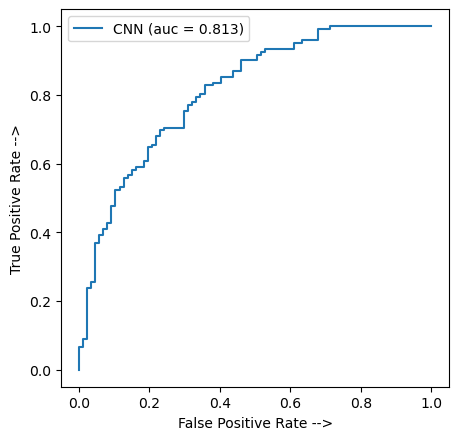

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_encoded, y_pred_load[:,1])
auc_cnn = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'CNN (auc = %0.3f)' % auc_cnn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()